# Data Analysis Interview Challenge, Part 3: Predictive Modeling

## Introduction

<span style="color:navy">
    <p><b>Instructions</b>: Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e., took a trip) in the preceding 30 days.</p>
    <p>We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.</p>
    <p>The data is in the attached file <i>ultimate_data_challenge.json</i>. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.</p>
    <ol>
        <li>Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?</li>
        <li>Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.</li>
        <li>Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).</li>
    </ol>
</span>

**Data Description**

| name | description |
| --- | --- |
| city | city this user signed up in |
| phone | primary device of this user |
| signup_date | date of account registration; in the form 'YYYYMMDD' |
| last_trip_date | the last time this user completed a trip; in the form 'YYYYMMDD' |
| avg_dist | the average distance in miles per trip taken in the first 30 days after signup |
| avg_rating_by_driver | rider's average rating over all of their trips |
| avg_rating_of_driver | rider's average rating of their drivers over all of their trips |
| surge_pct | percent of trips taken with surge multiplier > 1 |
| avg_surge | average surge multiplier |
| trips_in_first_30_days | number of trips this user took in the first 30 days after signing up |
| ultimate_black_user | TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise |
| weekday_pct | percent of the user's trips occurring during a weekday |

Aside: what [surge](https://www.ridester.com/surge-pricing/) is.

## Loading and Examining Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_json(".\\data\\ultimate_data_challenge.json")
df.shape

(50000, 12)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [4]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


This dataset contains 50000 users. From a glance, we can see there are some missing values in the features, but most of the dataset seems populated. We do not have an explicit column that would represent our dependent variable $y$, whether a user is retained/active. This we will have to make based on if they took a trip in the preceding 30 days.

In [5]:
# convert signup_date, last_trip_date to datetime
#df.apply()
df['signup_date'] = df['signup_date'].astype('datetime64[ns]')
df['last_trip_date'] = df['last_trip_date'].astype('datetime64[ns]')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

### Date data

In [7]:
df.signup_date.describe(datetime_is_numeric=True)

count                         50000
mean     2014-01-16 13:04:20.352000
min             2014-01-01 00:00:00
25%             2014-01-09 00:00:00
50%             2014-01-17 00:00:00
75%             2014-01-24 00:00:00
max             2014-01-31 00:00:00
Name: signup_date, dtype: object

The range matches our original statement: these users signed up in January 2014.

In [8]:
df.last_trip_date.describe(datetime_is_numeric=True)

count                            50000
mean     2014-04-19 08:02:04.992000256
min                2014-01-01 00:00:00
25%                2014-02-14 00:00:00
50%                2014-05-08 00:00:00
75%                2014-06-18 00:00:00
max                2014-07-01 00:00:00
Name: last_trip_date, dtype: object

Our latest date is the first of July. The range makes sense, and now we know that when our project specs says "several months later", it means 6 months.

### Numerical data

In [9]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


Of our numerical columns, nothing really jumps from `avg_rating_of_driver`, `surge_pct`, `weekday_pct`, and `avg_rating_by_driver`, but the `trips_in_first_30_days`, `avg_surge`, and `avg_dist` have some outliers that we will look over.

125 trips in 30 days seems like quite the outlier, but this is about 4-5 trips per day, which is actually not that strange if they happen to be a consistently very mobile person. Another possibility is that they share their account with others.

In [10]:
df[df['trips_in_first_30_days'] == 125]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8


Their average distance per trip looks small to me, so it could be that they just request a ride for lots of short distances. This user's `last_trip_date` is pretty recent.

In [11]:
def plot_hist(df, column_name, title="", xlabel="", ylabel=""):
    """
    Plots a histogram for a column from a DataFrame.
    
    df : The dataframe containing the information to plot.
    column_name : The name of the column in the df to plot.
    title : The title of the plot.
    xlabel : The name of the xlabel.
    ylabel : The name of the ylabel.
    KeyError: can TODO - column_name should exist in df
    """
    _ = plt.hist(df[column_name], bins=int(np.ceil(np.log2(len(df[column_name]))) + 1))
    _ = plt.title(title)
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel(ylabel)
    _ = plt.show()

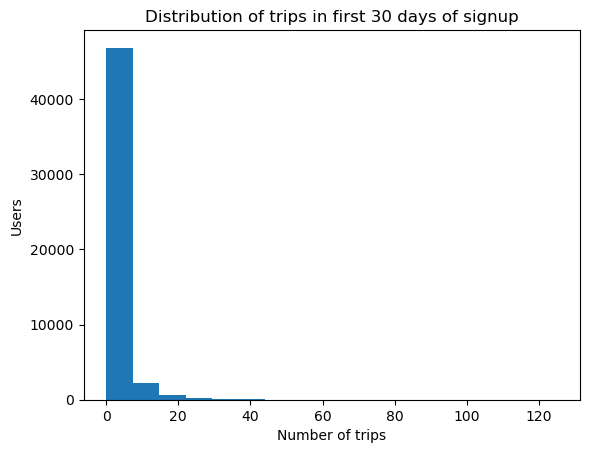

In [12]:
plot_hist(df, 'trips_in_first_30_days',
          title="Distribution of trips in first 30 days of signup",
          xlabel="Number of trips",
          ylabel="Users")

In [13]:
df[df['trips_in_first_30_days'] > 40].describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,52.028571,4.651429,1.058571,7.140000,74.985714,3.090286,4.694286
std,14.894700,0.424521,0.053586,6.579701,7.579428,1.580764,0.143369
min,41.000000,3.100000,1.000000,0.000000,58.800000,1.140000,4.400000
25%,44.000000,4.600000,1.020000,3.150000,70.050000,2.105000,4.600000
50%,48.000000,4.800000,1.050000,5.400000,73.900000,2.740000,4.700000
75%,54.500000,4.950000,1.085000,8.800000,79.150000,3.425000,4.800000
max,125.000000,5.000000,1.250000,33.600000,89.700000,8.170000,5.000000


It looks like there could be a pattern of behaviors in these users who have a lot of trips in their first 30 days of signup. They are generally weekday users (the minimum percentage is 59%), who travel short-to-moderate distances during or in low-surge times and areas (the values in the average distance and surge columns are generally medium-to-low and low).

In [14]:
df[df['avg_surge'] == 8]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
13861,Winterfell,1,2014-01-01,1.0,8.0,2014-01-01,iPhone,100.0,False,100.0,5.77,5.0


This user does not look so happy with his one day of trip with the 8x multiplier... I probably wouldn't be happy with an 8x cost either, so this could be a reasonable row overall.

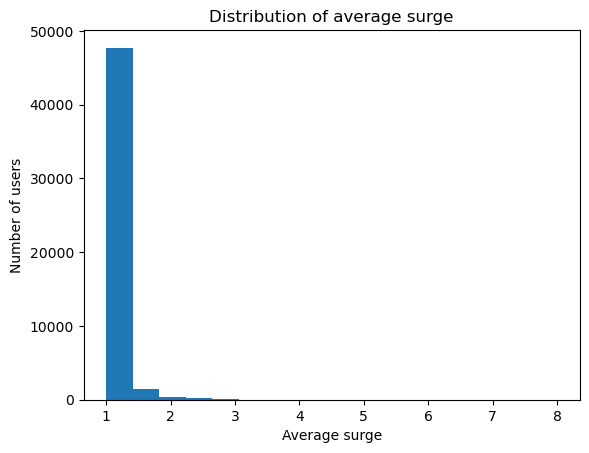

In [15]:
plot_hist(df, 'avg_surge',
          title="Distribution of average surge",
          xlabel="Average surge",
          ylabel="Number of users")

In [16]:
df[(df['avg_surge'] > 2) & (df['avg_surge'] < 8)].describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,466.000000,290.000000,466.000000,466.000000,466.000000,466.000000,458.000000
mean,0.757511,4.394483,2.705494,94.281545,39.260300,4.554227,4.797380
std,0.741400,0.966446,0.570755,15.131088,46.906802,4.010222,0.631758
min,0.000000,1.000000,2.070000,33.300000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,2.250000,100.000000,0.000000,2.030000,5.000000
50%,1.000000,5.000000,2.500000,100.000000,0.000000,3.345000,5.000000
75%,1.000000,5.000000,3.000000,100.000000,100.000000,5.410000,5.000000
max,6.000000,5.000000,5.750000,100.000000,100.000000,26.570000,5.000000


The outlier of 8 `avg_surge` is not that weird, since he has had only one trip (or perhaps only used the app for one day), whereas the average of others can be nearly 6x, meaning that the true range of surge is likely much higher than 6x.

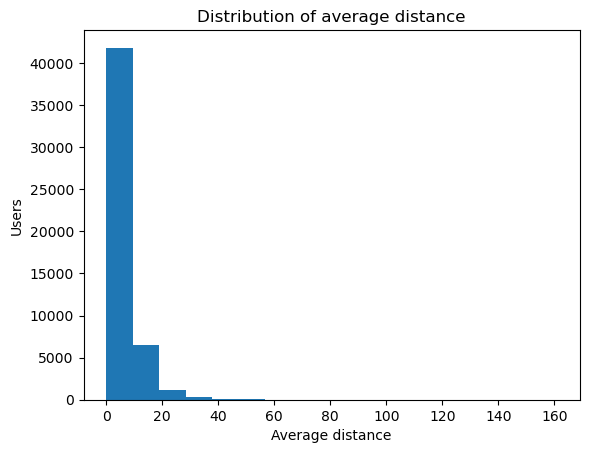

In [17]:
plot_hist(df, 'avg_dist',
          title="Distribution of average distance",
          xlabel="Average distance",
          ylabel="Users")

In [18]:
df.sort_values(by='avg_dist', ascending=False).head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
20701,Astapor,0,2014-01-25,NaN,1.0,2014-06-26,Android,0.0,False,100.0,160.96,NaN
534,King's Landing,0,2014-01-04,NaN,1.0,2014-03-09,None,0.0,False,0.0,129.89,5.0
1302,Winterfell,1,2014-01-30,5.0,1.0,2014-01-30,iPhone,0.0,False,100.0,79.69,5.0
22290,Astapor,0,2014-01-12,5.0,1.0,2014-06-26,iPhone,0.0,True,100.0,79.34,5.0
47595,King's Landing,0,2014-01-25,5.0,1.0,2014-06-09,iPhone,0.0,True,0.0,77.13,5.0


### Categorical data

In [19]:
print(df.city.value_counts())

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64


In [20]:
print(df.phone.value_counts())

iPhone     34582
Android    15022
Name: phone, dtype: int64


In [21]:
df.phone.value_counts()[0] / (df.phone.value_counts()[0] + df.phone.value_counts()[1])

0.69716151923232

About 70% of the phones are iPhones.

In [22]:
phone_in_city = df.groupby(by=['phone', 'city']).count()['signup_date']
phone_in_city

phone    city          
Android  Astapor            5244
         King's Landing     2498
         Winterfell         7280
iPhone   Astapor           11169
         King's Landing     7568
         Winterfell        15845
Name: signup_date, dtype: int64

In [23]:
cities = df.city.unique()
phone_counts = {'Android': [], 'iPhone': []}
for phone in phone_counts.keys():
    for city in cities:
        phone_counts[phone].append(phone_in_city[phone][city])
print(phone_counts)

{'Android': [2498, 5244, 7280], 'iPhone': [7568, 11169, 15845]}


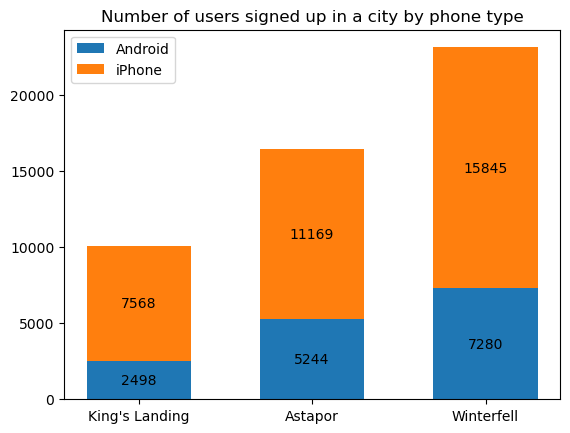

In [24]:
width = 0.6
bottom = np.zeros(3)

fig, ax = plt.subplots()

for phone_type, phone_count in phone_counts.items():
    p = ax.bar(cities, phone_count, width, label=phone_type, bottom=bottom)
    bottom += phone_count
    ax.bar_label(p, label_type='center')

ax.set_title("Number of users signed up in a city by phone type")
ax.legend(loc="upper left")
plt.show()

Most people signed up in Winterfell and the least amount of people signed up in King's Landing. They have roughly equal distributions of phone types in each city, but King's Landing has a slightly higher proportion of iPhone users.

## Missing Values

In [25]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns = ['count', '%']
missing = missing.sort_values(by='%', ascending=False)
missing[missing['%'] > 0]

,count,%
avg_rating_of_driver,8122,16.244
phone,396,0.792
avg_rating_by_driver,201,0.402


### Missing `avg_rating...` values

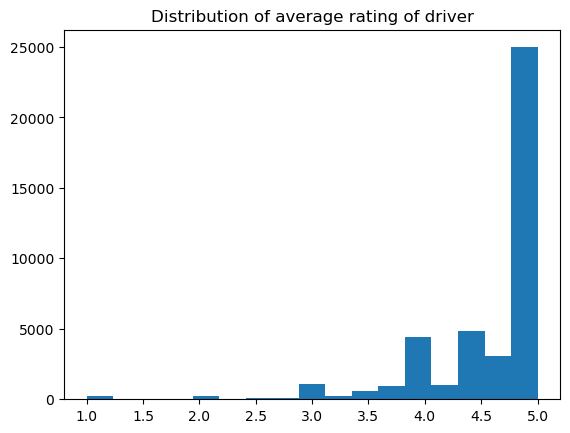

In [26]:
plot_hist(df, 'avg_rating_of_driver',
          title="Distribution of average rating of driver")

In [27]:
df['avg_rating_of_driver'].describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

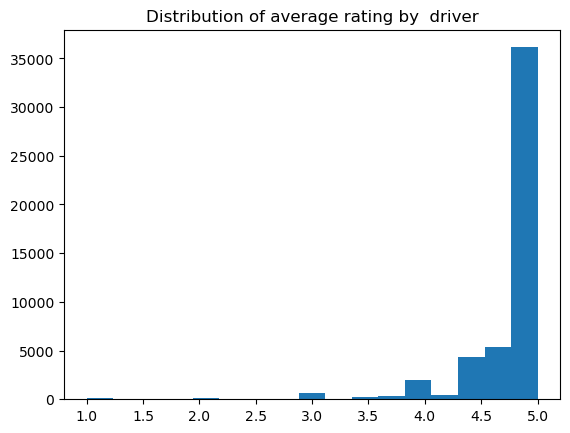

In [28]:
plot_hist(df, 'avg_rating_by_driver',
          title="Distribution of average rating by  driver")

In [29]:
df['avg_rating_by_driver'].describe()

count    49799.000000
mean         4.778158
std          0.446652
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

The missing values for these will just be simply imputed as the average.

In [30]:
df.fillna(value=
              {'avg_rating_of_driver': df['avg_rating_of_driver'].mean(),
               'avg_rating_by_driver': df['avg_rating_by_driver'].mean()},
          inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [32]:
df[['avg_rating_of_driver', 'avg_rating_by_driver']].describe()

,avg_rating_of_driver,avg_rating_by_driver
count,50000.000000,50000.000000
mean,4.601559,4.778158
std,0.564977,0.445753
min,1.000000,1.000000
25%,4.500000,4.700000
50%,4.700000,5.000000
75%,5.000000,5.000000
max,5.000000,5.000000


### Missing `phone` values

With categorical data, we can either simply impute with the mode (iPhone) or try to retain some of the distribution. I will go with the latter. Recall that we had about 70% iPhones. "King's Landing" had about 75% iPhones, but this may be close enough.

In [33]:
pct_iphone = df.phone.value_counts()[0] / (df.phone.value_counts()[0] + df.phone.value_counts()[1])
pct_iphone

0.69716151923232

In [34]:
def make_random_phones(pct_iphone, num_phones, seed=23):
    """
    Generates random phones as an iPhone or Android, depending on the percentage of iPhones.
    pct_iphones : the threshold percentage (<= 1) for a phone to be considered an iPhone.
    num_phones : the number of phones to generate.
    seed : the seed for the random number generator for reproducibility.
    """
    rng = np.random.default_rng(seed=seed)
    rng_arr = rng.random((num_phones, 1))
    phone = []
    for rn in rng_arr:
        if rn <= pct_iphone:
            phone.append('iPhone')
        else:
            phone.append('Android')
    return phone

In [35]:
random_phones = make_random_phones(pct_iphone, df['phone'].isna().sum())

In [36]:
j = 0
for i in df[df['phone'].isna()]['phone'].index:
    df.loc[i, 'phone'] = random_phones[j]
    j += 1

In [37]:
print("{}: {} units, {}%\n{}: {} units, {}%\n".format(
        df.phone.value_counts().index[0], df.phone.value_counts()[0], round(df.phone.value_counts()[0]/len(df) * 100, 2),
        df.phone.value_counts().index[1], df.phone.value_counts()[1], round(df.phone.value_counts()[1]/len(df) * 100, 2)))

iPhone: 34851 units, 69.7%
Android: 15149 units, 30.3%



In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

## Response Variable

Now to establish which users are still active. As defined by the project guidelines, active users are those who were active in the last 30 days.

In [39]:
max_date = df.last_trip_date.max()
print(max_date)

2014-07-01 00:00:00


In [40]:
print("{} users were active in the last 30 days".format(
    len(df[df['last_trip_date'] >= (max_date - pd.Timedelta(30, unit='days'))])))

18804 users were active in the last 30 days


In [41]:
df['active'] = [1 if last_date >= (max_date - pd.Timedelta(30, unit='days')) else 0 for last_date in df.last_trip_date]

In [42]:
df.active.sum()

18804

In [43]:
print("Fraction of users retained: {}/{}\nPercent of users retained: {}".format(
    df.active.sum(), len(df), df.active.sum() / len(df)))

Fraction of users retained: 18804/50000
Percent of users retained: 0.37608


We have some class imbalance.

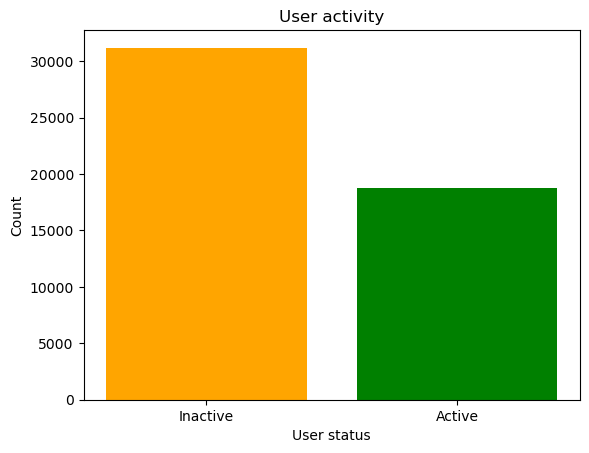

In [44]:
fig, ax = plt.subplots()
_ = ax.bar(['Inactive', 'Active'], height=df['active'].value_counts().values, color=['orange', 'green'])
_ = ax.set_title("User activity")
_ = plt.xlabel("User status")
_ = plt.ylabel("Count")

plt.show()

### Exploratory Data Analysis

#### Helper functions

In [45]:
def make_activity_cat_dict(df, x_cats, col_name):
    """
    Counts the number of inactive and active users for a given category.
    
    x_cats : The categories to count.
    col_name : The column name corresponding to the categories.
    """
    cat_activity = {'inactive':[], 'active':[]}
    for cat in x_cats:
        active_users = df[(df[col_name] == cat)]['active'].sum()
        inactive_users = len(df[(df[col_name] == cat)]) - active_users
        cat_activity['inactive'].append(inactive_users)
        cat_activity['active'].append(active_users)
    return cat_activity

In [46]:
def plot_bar_by_activity(x_cats, group_dict, title="", legend_loc=None, xlabel="", ylabel="", width=0.25):
    """
    Plots a bar chart for a category, grouping them horizontally into inactive and active groups, and coloring
    inactive groups orange and active groups green.
    
    x_cats : The categories to graph. The order should match the group_dict list of numbers.
    group_dict : A dictionary containing 'inactive' and 'active' keys with numbers that correspond to the x_cats.
    title : The title to give the plot.
    legend_loc : Controls where the legend will be on the plot.
    xlabel : Name of the x-label.
    ylabel : Name of the y-label.
    width : The width of the bars.
    """
    # set up variables
    x = np.arange(len(x_cats))
    multiplier = 0
    
    fig, ax = plt.subplots()
    for group, value in group_dict.items():
        # position
        offset = width * multiplier
        # bars
        bars = ax.bar(x + offset, value, width, label=group)
        # colors
        for b in bars.patches:
            if (group == 'inactive'):
                b.set(color='orange')
            else:
                b.set(color='green')
        
        ax.bar_label(bars, padding=3)
        multiplier += 1
    
    # title, legend, and labels
    ax.set_title(title)
    ax.set_xticks(x + (width)/len(group_dict), x_cats)
    ax.legend(loc=legend_loc)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # dynamically adjusts the height to contain the values better
    ax.set_ylim(0, np.max(np.array([v for v in group_dict.values()]).flatten())
               + np.ceil(np.std(np.array([v for v in group_dict.values()]).flatten())))
    
    _ = plt.show()

In [47]:
def plot_violin_by_activity(inactive_values, active_values, title="", xlabel="User activity", ylabel=""):
    """
    Plots a violin chart, grouped by activity and colored orange for inactive and green for active.
    
    inactive_values : The data for inactive users.
    active_values : The data for active users.
    title : The title to give the plot.
    xlabel : Name of the x-label.
    ylabel : Name of the y-label.
    """
    # aggregate the values
    all_values = [inactive_values, active_values]
    
    fig, ax = plt.subplots()
    violin = ax.violinplot(all_values)
    # colors
    violin['bodies'][0].set(color='orange')
    violin['bodies'][1].set(color='green')
    
    # title, labels
    ax.set_title(title)
    ax.set_xticks([y + 1 for y in range(len(all_values))], labels=['inactive', 'active'])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    _ = plt.show()

In [48]:
def plot_box_by_activity(inactive_values, active_values, title="", xlabel="", ylabel=""):
    """
    Plots a box chart, grouped by activity and colored orange for inactive and green for active.
    
    inactive_values : The data for inactive users.
    active_values : The data for active users.
    title : The title to give the plot.
    xlabel : Name of the x-label.
    ylabel : Name of the y-label.
    """
    # aggregate the values
    all_values = [inactive_values, active_values]
    
    fig, ax = plt.subplots()
    box = ax.boxplot(all_values)
    
    # colors
    box['boxes'][0].set(color='orange')
    box['boxes'][1].set(color='green')
    box['medians'][0].set(color='blue')
    box['medians'][1].set(color='blue')
    
    # title, labels
    ax.set_title(title)
    ax.set_xticks([y + 1 for y in range(len(all_values))], labels=['inactive', 'active'])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    _ = plt.show()

#### By `city`

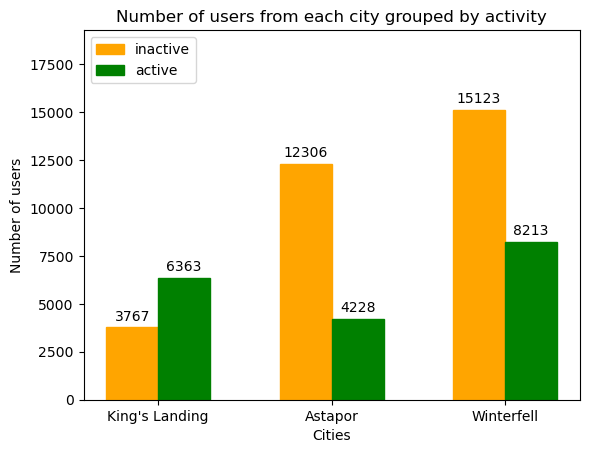

In [49]:
cities = df.city.unique()

plot_bar_by_activity(cities, make_activity_cat_dict(df, cities, 'city'),
                     title="Number of users from each city grouped by activity",
                     legend_loc="upper left",
                     xlabel="Cities",
                     ylabel="Number of users",
                     width=0.3)

Most users from 'Astapor' and 'Winterfell' are inactive now, but "King's Landing" still has a lot of active users. It also looks like 'Astapor' has a slightly greater ratio of inactive users to active users compared to 'Winterfell'.

#### By `trips_in_first_30_days`

In [50]:
df[df['active'] == 0]['trips_in_first_30_days'].describe()

count    31196.000000
mean         1.658482
std          2.654222
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         73.000000
Name: trips_in_first_30_days, dtype: float64

In [51]:
df[df['active'] == 1]['trips_in_first_30_days'].describe()

count    18804.000000
mean         3.306318
std          4.986743
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max        125.000000
Name: trips_in_first_30_days, dtype: float64

In [52]:
df[(df['active'] == 1) & (df['trips_in_first_30_days'] < 125)]['trips_in_first_30_days'].describe()

count    18803.000000
mean         3.299846
std          4.907264
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max         71.000000
Name: trips_in_first_30_days, dtype: float64

The range for the `trips_in_first_30_days` is very wide, so a visualization for its distribution will be skewed and the information will be more obscure. By looking at the summary statistics though, we can see that active users tended to have more trips in their first 30 days. Their mean may be skewed, but the median is still higher, and even when we filter out the outlier of the active dataset, the mean is still higher than that of the inactive people.

In [53]:
x_active = df[df['active'] == 1]['trips_in_first_30_days'].values
x_inactive = df[df['active'] == 0]['trips_in_first_30_days'].values

#### By `signup_date`

In [54]:
jan_daily_df = pd.DataFrame(pd.date_range(start=df['signup_date'].min(), end=df['signup_date'].max(), freq='D')).rename(columns={0:'signup_date'})

In [55]:
signup_inactive_df = pd.DataFrame(df[df['active'] == 0]['signup_date'].value_counts()).reset_index() \
                     .rename(columns={'signup_date':'inactive', 'index':'date'})
signup_active_df = pd.DataFrame(df[df['active'] == 1]['signup_date'].value_counts()).reset_index() \
                     .rename(columns={'signup_date':'active', 'index':'date'})

In [56]:
signup_inactive_df.rename(columns={'date':'signup_date'}, inplace=True)
signup_active_df.rename(columns={'date':'signup_date'}, inplace=True)

In [57]:
signup_inactive_df.sort_values(by='signup_date', inplace=True)
signup_inactive_df.reset_index(drop=True, inplace=True)

signup_active_df.sort_values(by='signup_date', inplace=True)
signup_active_df.reset_index(drop=True, inplace=True)

In [58]:
jan_daily_df = pd.concat([jan_daily_df,
                          signup_inactive_df.drop(columns='signup_date'),
                          signup_active_df.drop(columns='signup_date')], axis=1)

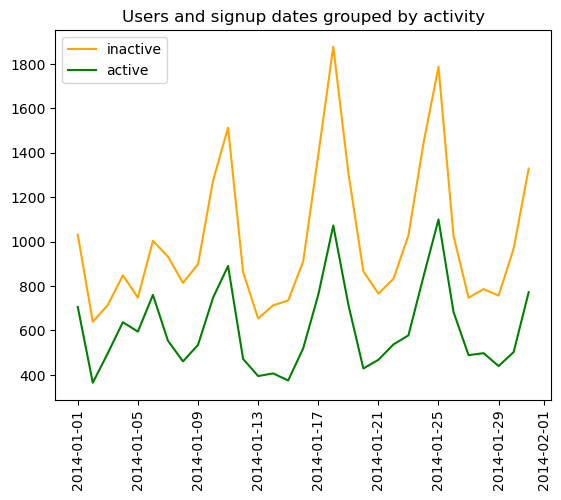

In [59]:
fig, ax = plt.subplots()
_ = ax.plot(jan_daily_df['signup_date'], jan_daily_df['inactive'], label='inactive', color='orange')
_ = ax.plot(jan_daily_df['signup_date'], jan_daily_df['active'], label='active', color='green')
_ = plt.title("Users and signup dates grouped by activity")
_ = plt.legend()
_ = plt.xticks(rotation=90)
_ = plt.show()

There's no difference in the pattern.

#### By `avg_rating_of_driver`

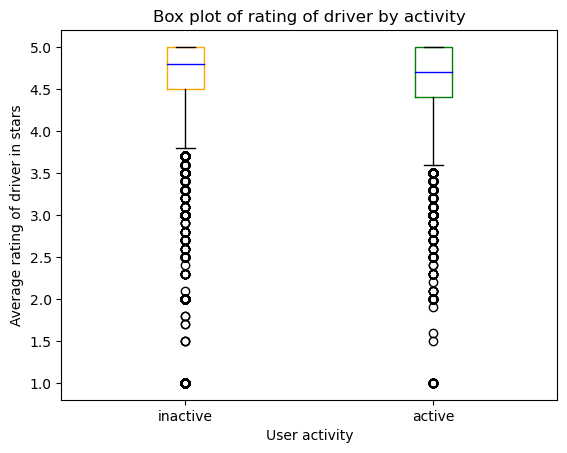

In [60]:
plot_box_by_activity(df[df['active'] == 0]['avg_rating_of_driver'].values,
                        df[df['active'] == 1]['avg_rating_of_driver'].values,
                        title="Box plot of rating of driver by activity",
                        xlabel="User activity",
                        ylabel="Average rating of driver in stars")

Active users tend to rate the driver lower.

#### By `avg_surge`

In [61]:
df[df['active'] == 0]['avg_surge'].describe()

count    31196.000000
mean         1.075339
std          0.251361
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: avg_surge, dtype: float64

In [62]:
df[df['active'] == 1]['avg_surge'].describe()

count    18804.000000
mean         1.073809
std          0.163170
min          1.000000
25%          1.000000
50%          1.000000
75%          1.090000
max          4.500000
Name: avg_surge, dtype: float64

The surge doesn't seem to differ very much, but the max value of the inactive users is higher.

#### By `last_trip_date`
The response variable is constructed using this value.

#### By `phone`

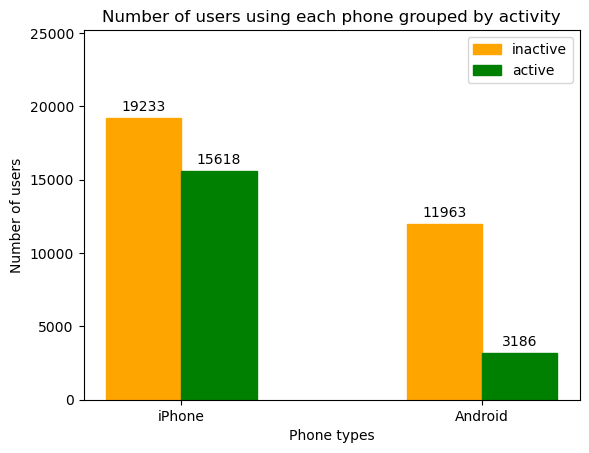

In [63]:
phones = df.phone.unique()

plot_bar_by_activity(phones, make_activity_cat_dict(df, phones, 'phone'),
                     title="Number of users using each phone grouped by activity",
                     legend_loc="upper right",
                     xlabel="Phone types",
                     ylabel="Number of users",
                     width=0.25)

Our Android users are not very active.

#### By `surge_pct`

In [64]:
df[df['active'] == 0]['surge_pct'].describe()

count    31196.000000
mean         8.666739
std         22.179139
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        100.000000
Name: surge_pct, dtype: float64

In [65]:
df[df['active'] == 1]['surge_pct'].describe()

count    18804.000000
mean         9.152797
std         15.588704
min          0.000000
25%          0.000000
50%          0.000000
75%         13.300000
max        100.000000
Name: surge_pct, dtype: float64

Most of the `surge_pct` seems to be 0, regardless of whether the user is active or not.

In [66]:
len(df[(df['active'] == 0) & (df['surge_pct'] == 0)]['surge_pct']) / len(df[(df['active'] == 0)])

0.7914796768816514

In [67]:
len(df[(df['active'] == 1) & (df['surge_pct'] == 0)]['surge_pct']) / len(df[(df['active'] == 1)])

0.5168049351201872

However, there is a slightly larger percentage of users who are active that have a nonzero `surge_pct`. In other words, active users tend to be more likely to order a trip during high surge, but we don't know the number of trips that each user ordered, so we don't know if they have more surge trips because they also order more trips in general.

#### By `ultimate_black_user`

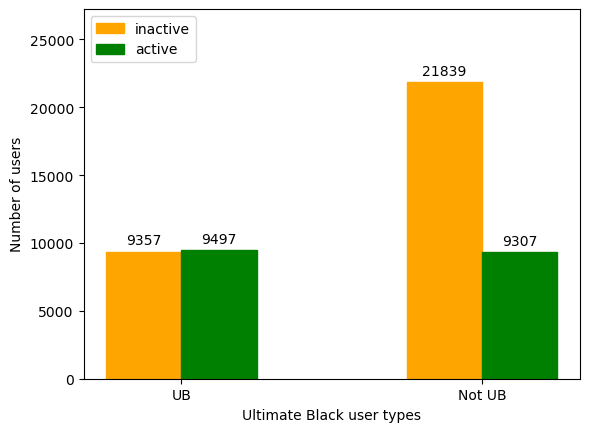

In [68]:
ub_not_ub_TF = df.ultimate_black_user.unique()

plot_bar_by_activity(['UB' if i else 'Not UB' for i in ub_not_ub_TF],
                     make_activity_cat_dict(df, ub_not_ub_TF, 'ultimate_black_user'),
                     legend_loc="upper left",
                     xlabel="Ultimate Black user types",
                     ylabel="Number of users",
                     width=0.25)

Our Ultimate Black users tend to remain active.

#### By `weekday_pct`

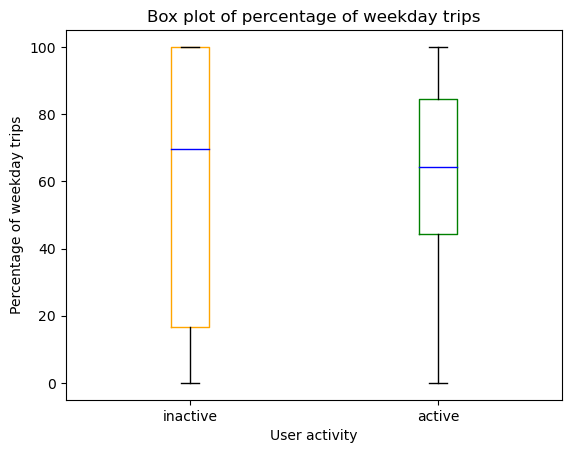

In [69]:
plot_box_by_activity(df[df['active'] == 0]['weekday_pct'].values,
                     df[df['active'] == 1]['weekday_pct'].values,
                     title="Box plot of percentage of weekday trips",
                     xlabel="User activity",
                     ylabel="Percentage of weekday trips")

Active users have a lower median of `weekday_pct`, but their distribution is more tightly centered around having half or more weekday trips. Inactive users tend to be more diverse in their days of the week.

#### By `avg_dist`

In [70]:
df[(df['active'] == 0) & (df['avg_dist'] < 129)]['avg_dist'].describe()

count    31195.000000
mean         6.203974
std          6.199348
min          0.000000
25%          2.320000
50%          4.030000
75%          7.800000
max         79.690000
Name: avg_dist, dtype: float64

In [71]:
df[(df['active'] == 1) & (df['avg_dist'] < 160)]['avg_dist'].describe()

count    18803.000000
mean         5.106500
std          4.473158
min          0.000000
25%          2.560000
50%          3.730000
75%          5.890000
max         79.340000
Name: avg_dist, dtype: float64

Inactive users seem to travel longer distances, when disregarding the top outliers from both groups.

#### By `avg_rating_by_driver`

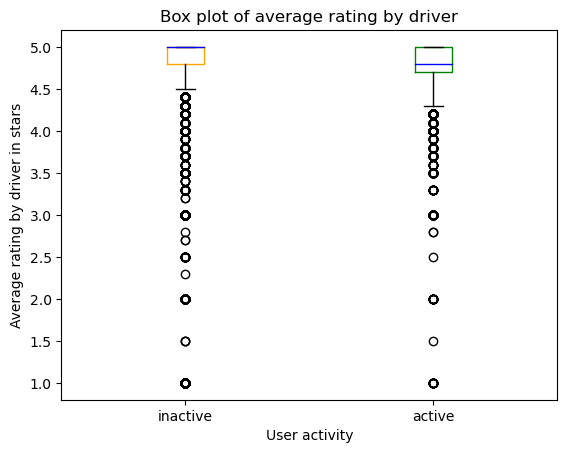

In [72]:
plot_box_by_activity(df[df['active'] == 0]['avg_rating_by_driver'].values,
                     df[df['active'] == 1]['avg_rating_by_driver'].values,
                     title="Box plot of average rating by driver",
                     xlabel="User activity",
                     ylabel="Average rating by driver in stars")

The inactive riders tend to have a higher average rating.

### Summary

Active users tended to follow these patterns:
- `city`: King's Landing users were overall fewer in number, but they have a high ratio of remaining active.
- `trips_in_first_30_days`: Active users ordered more trips in their first 30 days of signup.
- `avg_rating_of_driver`: Active users tended to rate the drivers lower.
- `phone`: iPhone users have a better ratio of active users to inactive users, being almost even.
- `ultimate_black_user`: UB users tend to have a better ratio of active users than inactive users, being almost even, but there are also not that many UB users.
- `weekday_pct`: Inactive users have a high distribution of weekday and non-weekday percentages, whereas active users tend have around 44-84% weekday percentages.
- `avg_dist`: When disregarding outliers, active users tend to have shorter distance.
- `avg_rating_by_driver`: Drivers tended to rate active users lower.

## Preprocessing and Modeling

Our response variable $y$ is whether the user is `active` or not, making this a supervised classification problem.

We have two categorical features that should be encoded: `city` and `phone`.

In [73]:
df = df.astype({'city':'category','phone':'category'})

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  category      
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  category      
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  active                  50000 non-null  int64 

In [75]:
# The first time I ran through models, I had drop_first=True
# I tested without it because I thought the interpretation might be a bit easier for me
# It turned out that having drop_first=True resulted in the same or slightly worse results for the models
#enc_df = pd.get_dummies(df, drop_first=True)
enc_df = pd.get_dummies(df)
enc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  50000 non-null  int64         
 1   signup_date             50000 non-null  datetime64[ns]
 2   avg_rating_of_driver    50000 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   last_trip_date          50000 non-null  datetime64[ns]
 5   surge_pct               50000 non-null  float64       
 6   ultimate_black_user     50000 non-null  bool          
 7   weekday_pct             50000 non-null  float64       
 8   avg_dist                50000 non-null  float64       
 9   avg_rating_by_driver    50000 non-null  float64       
 10  active                  50000 non-null  int64         
 11  city_Astapor            50000 non-null  uint8         
 12  city_King's Landing     50000 non-null  uint8 

In [76]:
X = enc_df.drop(columns=['signup_date', 'last_trip_date', 'active'])
y = enc_df['active'].values
print(X.shape, y.shape)

(50000, 13) (50000,)


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

In [78]:
def get_score(clf, X_train, y_train, X_test, y_test):
    """
    Simply returns an accuracy score of the classifier.
    
    clf : Classifier that should adhere to sklearn Pipeline.
    X_train : X for training.
    y_train : y for training.
    X_test : Test X for validation.
    y_test : Test y for validation.
    """
    pipe = make_pipeline(StandardScaler(), clf)
    pipe = pipe.fit(X_train, y_train)
    return pipe.score(X_test, y_test)

In [79]:
score_dict = {}
classifiers = {'LogisticRegression': LogisticRegression(random_state=23),
              'LinearSVC': svm.LinearSVC(),
              'KNClassifier': KNeighborsClassifier(),
              'RFClassifier': RandomForestClassifier()}

In [80]:
for clf_name, clf in classifiers.items():
    score_dict[clf_name] = get_score(clf, X_train, y_train, X_test, y_test)

C:\Users\chian\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\chian\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [81]:
pd.Series(score_dict).sort_values(ascending=False)

RFClassifier          0.758400
KNClassifier          0.747333
LinearSVC             0.717667
LogisticRegression    0.716133
dtype: float64

We'll try the `RandomForestClassifier`. These were done with default values, so there is more that could be done with the others.

In [82]:
rfc_pipe = Pipeline(steps=[('scaler',StandardScaler()),
                           ('rfc', RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=23))])
params = {'rfc__n_estimators': [100, 200, 250],
         'rfc__max_features': ['sqrt', 1.0]}

In [83]:
gridCV = GridSearchCV(estimator=rfc_pipe, param_grid=params)

In [84]:
gridCV.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rfc',
                                        RandomForestClassifier(criterion='entropy',
                                                               n_jobs=-1,
                                                               random_state=23))]),
             param_grid={'rfc__max_features': ['sqrt', 1.0],
                         'rfc__n_estimators': [100, 200, 250]})

In [85]:
gridCV.best_params_

{'rfc__max_features': 1.0, 'rfc__n_estimators': 250}

In [86]:
gridCV.best_score_

0.7591428571428572

In [87]:
pd.DataFrame(gridCV.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__max_features,param_rfc__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.538672,1.434742,0.060926,0.011074,sqrt,100,"{'rfc__max_features': 'sqrt', 'rfc__n_estimato...",0.751000,0.750857,0.754714,0.753857,0.752857,0.752657,0.001530,6
1,1.512910,0.038458,0.086359,0.003608,sqrt,200,"{'rfc__max_features': 'sqrt', 'rfc__n_estimato...",0.749286,0.751429,0.757571,0.752857,0.752429,0.752714,0.002724,5
2,1.842718,0.080280,0.112691,0.010172,sqrt,250,"{'rfc__max_features': 'sqrt', 'rfc__n_estimato...",0.750143,0.751714,0.757857,0.753571,0.753571,0.753371,0.002583,4
3,1.759162,0.048947,0.064087,0.015958,1.0,100,"{'rfc__max_features': 1.0, 'rfc__n_estimators'...",0.749571,0.759571,0.760000,0.757143,0.756571,0.756571,0.003744,3
4,3.353120,0.229272,0.105707,0.013171,1.0,200,"{'rfc__max_features': 1.0, 'rfc__n_estimators'...",0.752143,0.758857,0.763000,0.760429,0.759143,0.758714,0.003597,2
5,4.041626,0.272611,0.114654,0.013173,1.0,250,"{'rfc__max_features': 1.0, 'rfc__n_estimators'...",0.752857,0.759429,0.763286,0.760857,0.759286,0.759143,0.003456,1


In [88]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

In [89]:
best_rfc = gridCV.best_estimator_

In [90]:
best_rfc.score(X_test, y_test)

0.7588

C:\Users\chian\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


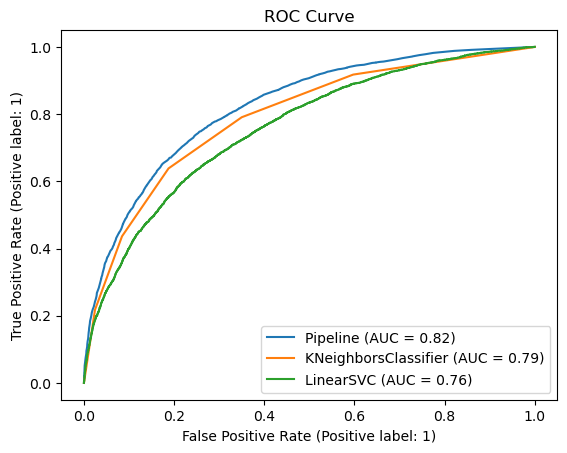

In [91]:
fig, ax = plt.subplots()

scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

rfc_roc_disp = RocCurveDisplay.from_estimator(best_rfc, X_test, y_test, ax=ax)
ax.set_title("ROC Curve")

kn_clf = KNeighborsClassifier().fit(X_train_sc, y_train)
kn_roc_disp = RocCurveDisplay.from_estimator(kn_clf, X_test_sc, y_test, ax=ax)

lsvc_clf = svm.LinearSVC().fit(X_train_sc, y_train)
lsvc_roc_disp = RocCurveDisplay.from_estimator(lsvc_clf, X_test_sc, y_test, ax=ax)

_ = plt.show()

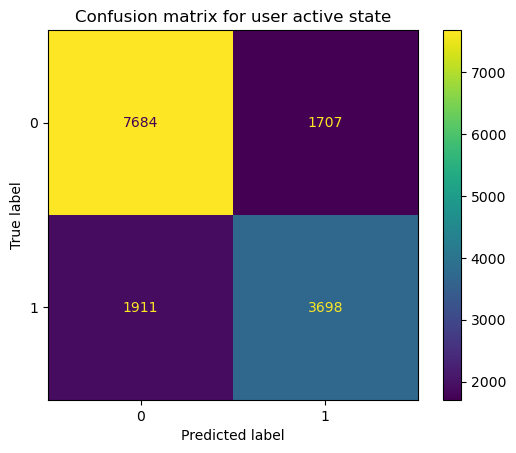

In [92]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(best_rfc, X_test, y_test, ax=ax)
ax.set_title("Confusion matrix for user active state")
_ = plt.show()

In [93]:
imps = best_rfc['rfc'].feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rfc['rfc'].estimators_], axis=0)
forest_imps = pd.Series(imps, index=gridCV.feature_names_in_)

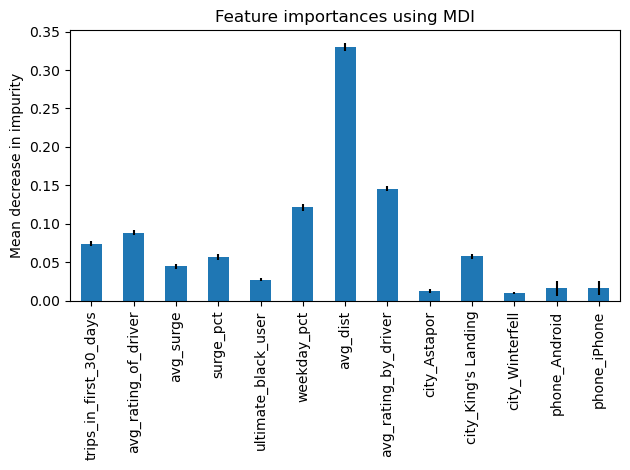

In [94]:
fig, ax = plt.subplots()
forest_imps.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [95]:
from sklearn.inspection import permutation_importance

In [96]:
res = permutation_importance(best_rfc['rfc'], best_rfc['scaler'].transform(X_test), y_test, n_repeats=20, random_state=23)
forest_permimps = pd.Series(res.importances_mean, index=gridCV.feature_names_in_)

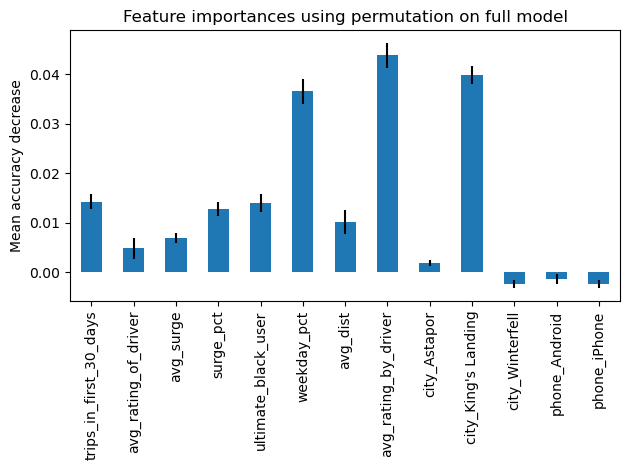

In [97]:
fig, ax = plt.subplots()
forest_permimps.plot.bar(yerr=res.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Conclusion

The fraction of users retained was 18804/50000 (37.6%), where a user is defined as retained/active is if their `last_trip_date` was within the last 30 days of the dataset window. This means that our dataset is mildly imbalanced, but it was not too troublesome for the models. I tested with the original dataset, and I tested with a downsampled dataset (of a factor of about 1.5), but the former was better or just fine in most models, so I deemed the loss of information not worth the imbalance.

I tested a few models out of the box (LogisticRegression, LinearSVC, KNeighborsClassifier, and RandomForestClassifier), and as such, there can be more experimentation done on them all, but I chose to tune the RandomForestClassifier further. In the initial baseline, they actually all had pretty decent accuracy.

| Name | Acc Score |
| --- | --- |
| RFClassifier | 0.7563 |
| KNClassifier | 0.7473 |
| LinearSVC | 0.7177 |
| LogisticRegression | 0.7161 |

The tuning did not improve performance by an extraordinary amount, only by about 0.0025, at a score of 0.7588, and the AUC came out to be 0.82, only 0.03 higher than that of the next best. The RandomForestClassifier is a bit slow to train, but we don't have that many features, so it actually did not take too long. When looking at the confusion matrix, the class imbalance is clear.

The feature importances were also examined. The random forest classifier's feature importances attribute top three seemed to be `avg_dist`, `avg_rating_by_driver`, and `weekday_pct`, whereas the top three from permutation importances were found to be the `avg_rating_by_driver`, `city_King's Landing`, and `weekday_pct`. From the EDA, I thought that `city`, `weekday_pct`, and `phone` would be among the most important features. The `avg_rating_by_driver` is a bit strange to me, but it does make sense because of how different the active and inactive distributions looked. (I suspect this feature actually expresses something else that is not explicitly present in the dataset--I am pretty sure that these inactive users having high, solid averages actually relates to the number of trips that they have had and to an overall rating behavior by the drivers, but this is mere speculation. I could speculate about that for ages.) The `avg_dist` was another feature that had a visible difference in distribution, so it also makes sense why the model might think it important.

For long-term rider retention, finding a way to encourage frequent short travels may be a good thing. I think the `avg_dist`, `avg_rating_by_driver`, and `weekday_pct` may hint at the behaviors of active and inactive riders. As I speculated above, a lower `avg_rating_by_driver` for active users probably actually has to do with the frequency that these active users have ordered trips. A shorter `avg_dist` and higher `weekday_pct` also hint to me about higher frequency of rides and shorter distance rides; I think they may have to do with a routine user. There are some other behavioral guesses that I could make about these types of riders: perhaps active users are frequent users who have to use the service often and therefore take more things about the drivers for granted as opposed to someone treating some less-experienced-experience as more unique or with more courtesy and care, or perhaps active users tip less because they use the service so much already, or perhaps people who use it routinely are using it for school or work and so are less happy or friendly than someone who is looking for a ride while on vacation or to drive to the airport. As for the `city`, I suspect "King's Landing" could either have a more affluent demographic (admittedly could be biased in associating "King" with affluence) or a more metropolitan environment where ridesharing would be more convenient than having your own vehicle. Whatever the reason may be, it could be worth it to research more into King's Landing or try to increase the user base in that location, especially since King's Landing has the least amount of users of the three cities (though again, this could also relate to the location characteristics, for instance population size).